# Estonian Pension Fund Fee Analysis (2022–2026)

Asset-weighted analysis of II and III pillar pension fund fees using public data from pensionikeskus.ee.

**Data sources:**
- TER (Total Expense Ratio or Ongoing Cost Figure) — scraped from pensionikeskus.ee fee comparison tables
- AUM (Assets Under Management) — downloaded daily net asset values, averaged annually

**Fee year mapping:** TER column year N = fees applicable to year N+1 (e.g. TER "2024" → analysis year 2025).

In [1]:
import sys, io, re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from bs4 import BeautifulSoup
from pathlib import Path

project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root / 'common' / 'scripts'))
from generate_charts import setup_plot_style, TULEVA_BLUE, TULEVA_NAVY, TULEVA_MID_BLUE

setup_plot_style()

# Provider color palette
PROVIDER_COLORS = {
    'Tuleva': TULEVA_NAVY,
    'LHV': '#FF4800',
    'Swedbank': '#F7A600',
    'SEB': '#51c26c',
    'Luminor': '#8B5CF6',
}
PROVIDER_ORDER = ['Tuleva', 'LHV', 'Swedbank', 'SEB', 'Luminor']
LATEST_YEAR = 2026

# Fund IDs on pensionikeskus.ee (for AUM downloads)
II_FUND_IDS = [36,37,38,39,47,48,49,50,51,52,57,58,59,60,61,73,74,75,76,77,80,86,88,91]
III_FUND_IDS = [32,33,34,41,42,43,53,55,72,79,81,84,85,87,89,90,93]

# III pillar: Estonian TER page name → English AUM name
III_NAME_MAP = {
    'LHV Pensionifond Aktiivne III': 'LHV Pensionifond Aktiivne III',
    'LHV Pensionifond Indeks III': 'LHV Pensionifond Indeks III',
    'Luminor Jätkusuutlik Tulevik 50-55 Indeks Pensionifond': 'Luminor Sustainable Future 50-55 Index Pension fund',
    'Luminor Tulevik 16-50 Pensionifond': 'Luminor Tulevik 16-50 Pension Fund',
    'Luminor Tulevik 55+ Pensionifond': 'Luminor Tulevik 55+ Pension Fund',
    'Luminor Tulevik Indeks Pensionifond': 'Luminor Future Index pension fund',
    'SEB III samba pensionifond 18+': 'SEB III Pillar Pension Fund 18+',
    'SEB III samba pensionifond 65+': 'SEB III Pillar Pension Fund 65+',
    'SEB kliimatuleviku pensionifond indeks': 'SEB Climate Future Pension Fund Index',
    'Swedbank III Samba Pensionifond Indeks': 'Swedbank III Pillar Pension Fund Index',
    'Swedbank Pensionifond V100': 'Swedbank Pension Fund V100',
    'Swedbank Pensionifond V100 indeks': 'Swedbank Pension Fund V100 index (limited redemption)',
    'Swedbank Pensionifond V100 indeks (väljumine piiratud)': 'Swedbank Pension Fund V100 index (limited redemption)',
    'Swedbank Pensionifond V30': 'Swedbank Pension Fund V30',
    'Swedbank Pensionifond V30 indeks': 'Swedbank Pension Fund V30 index (limited redemption)',
    'Swedbank Pensionifond V30 indeks (väljumine piiratud)': 'Swedbank Pension Fund V30 index (limited redemption)',
    'Swedbank Pensionifond V60': 'Swedbank Pension Fund V60',
    'Swedbank Pensionifond V60 indeks': 'Swedbank Pension Fund V60 index (limited redemption)',
    'Swedbank Pensionifond V60 indeks (väljumine piiratud)': 'Swedbank Pension Fund V60 index (limited redemption)',
    'Tuleva III Samba Pensionifond': 'Tuleva III Pillar Pension Fund',
}


def weighted_avg(ter, aum):
    """Asset-weighted average TER."""
    mask = ter.notna() & aum.notna() & (aum > 0)
    if mask.sum() == 0:
        return np.nan
    return (ter[mask] * aum[mask]).sum() / aum[mask].sum()


def parse_provider(name):
    for p in ['LHV', 'Luminor', 'SEB', 'Swedbank', 'Tuleva']:
        if p.lower() in name.lower():
            return p
    return 'Other'


def parse_strategy(name):
    return 'index' if re.search(r'indeks|index', name, re.IGNORECASE) else 'active'


def fetch_aum(pillar_path, fund_ids, date_from='2022-01-01', date_to='2026-02-23'):
    """Download daily AUM data from pensionikeskus.ee and compute annual averages."""
    params = '&'.join([f'f[{i}]={fid}' for i, fid in enumerate(fund_ids)])
    url = (f'https://www.pensionikeskus.ee/en/statistics/{pillar_path}'
           f'?download=xls&date_from={date_from}&date_to={date_to}&{params}')
    resp = requests.get(url)
    resp.raise_for_status()
    raw = pd.read_csv(io.BytesIO(resp.content), sep='\t', encoding='utf-16')
    raw['Fund'] = raw['Fund'].str.strip()
    raw = raw[~raw['Fund'].str.contains('Total|Kokku', case=False, na=False)]
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw['Net assets'] = pd.to_numeric(
        raw['Net assets'].astype(str).str.replace(',', '').str.replace(' ', ''),
        errors='coerce')
    raw['year'] = raw['Date'].dt.year
    aum = raw.groupby(['Fund', 'year'])['Net assets'].mean().reset_index()
    aum.columns = ['fund', 'year', 'avg_aum']
    return aum, raw


print('Setup complete')

Setup complete


In [2]:
# Fetch II pillar TER
url = 'https://www.pensionikeskus.ee/en/ii-pillar/funds-fees/funds-total-expense-ratio-comparison/'
resp = requests.get(url)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

headers = [th.get_text(strip=True) for th in rows[0].find_all(['th', 'td'])]
data = []
for row in rows[1:]:
    cells = [td.get_text(strip=True) for td in row.find_all(['td', 'th'])]
    if cells and cells[0]:
        data.append(cells)

df_ii_ter = pd.DataFrame(data, columns=headers)
df_ii_ter = df_ii_ter.rename(columns={headers[0]: 'fund'})
df_ii_ter['fund'] = df_ii_ter['fund'].str.strip()

year_cols_ii = [c for c in df_ii_ter.columns if c.isdigit()]
for col in year_cols_ii:
    df_ii_ter[col] = (df_ii_ter[col].str.replace('%', '').str.replace(',', '.')
                      .str.replace('–', '').str.replace('—', '').str.strip())
    df_ii_ter[col] = pd.to_numeric(df_ii_ter[col], errors='coerce')

print(f'II pillar TER: {len(df_ii_ter)} funds, year columns {year_cols_ii}')

# Display with dual header rows for year context
display_df = df_ii_ter.set_index('fund')
in_effect = pd.DataFrame([{c: int(c)+1 for c in display_df.columns}],
                         index=['Fees in effect →'])
audited = pd.DataFrame([{c: int(c) for c in display_df.columns}],
                       index=['Based on audited results of →'])
display_df = pd.concat([in_effect, audited, display_df])
display_df.columns = range(len(display_df.columns))  # hide header row
display_df.index.name = None

(display_df.style
 .format('{:.2f}', subset=pd.IndexSlice[display_df.index[2:], :])
 .format('{:.0f}', subset=pd.IndexSlice[display_df.index[:2], :])
 .set_properties(subset=pd.IndexSlice[display_df.index[:1], :],
                 **{'font-weight': 'bold', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[1:2], :],
                 **{'font-style': 'italic', 'color': '#666', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[2:], :],
                 **{'text-align': 'right'})
 .hide(axis='columns')
)

II pillar TER: 24 funds, year columns ['2021', '2022', '2023', '2024', '2025']


Fees in effect →,2022,2023,2024,2025,2026
Based on audited results of →,2021,2022,2023,2024,2025
LHV Pensionifond Ettevõtlik,1.62,1.95,1.56,1.48,1.57
LHV Pensionifond Indeks,0.33,0.32,0.32,0.30,0.27
LHV Pensionifond Julge,1.28,1.73,1.22,1.21,1.21
LHV Pensionifond Rahulik,0.53,0.55,0.57,0.54,0.53
LHV Pensionifond Tasakaalukas,1.17,1.25,1.09,1.14,1.13
Luminor 16-50 pension fund,1.44,1.30,1.18,1.13,1.08
Luminor 50-56 pension fund,1.43,1.33,1.23,1.17,1.13
Luminor 56+ pension fund,1.35,1.27,1.19,1.17,1.14
Luminor 61-65 pension fund,1.01,0.95,0.87,0.86,0.88


In [3]:
# Fetch III pillar TER (Estonian page → map names to English)
url = 'https://www.pensionikeskus.ee/iii-sammas/vabatahtlikud-fondid/jooksvate-tasude-vordlus/'
resp = requests.get(url)
resp.raise_for_status()

soup = BeautifulSoup(resp.text, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

headers = [th.get_text(strip=True) for th in rows[0].find_all(['th', 'td'])]
data = []
for row in rows[1:]:
    cells = [td.get_text(strip=True) for td in row.find_all(['td', 'th'])]
    if cells and cells[0]:
        data.append(cells)

df_iii_ter = pd.DataFrame(data, columns=headers)
df_iii_ter = df_iii_ter.rename(columns={headers[0]: 'fund'})
df_iii_ter['fund'] = df_iii_ter['fund'].str.strip()

year_cols_iii = [c for c in df_iii_ter.columns if c.isdigit()]
for col in year_cols_iii:
    df_iii_ter[col] = (df_iii_ter[col].str.replace('%', '').str.replace(',', '.')
                       .str.replace('–', '').str.replace('—', '').str.strip())
    df_iii_ter[col] = pd.to_numeric(df_iii_ter[col], errors='coerce')

# Map Estonian names to English
df_iii_ter['fund'] = df_iii_ter['fund'].map(III_NAME_MAP).fillna(df_iii_ter['fund'])
unmapped = df_iii_ter[~df_iii_ter['fund'].isin(III_NAME_MAP.values())]
if len(unmapped):
    print(f'WARNING: {len(unmapped)} unmapped III pillar funds: {unmapped["fund"].tolist()}')

print(f'III pillar TER: {len(df_iii_ter)} funds, year columns {year_cols_iii}')

# Display with dual header rows for year context
display_df = df_iii_ter.set_index('fund')
in_effect = pd.DataFrame([{c: int(c)+1 for c in display_df.columns}],
                         index=['Fees in effect →'])
audited = pd.DataFrame([{c: int(c) for c in display_df.columns}],
                       index=['Based on audited results of →'])
display_df = pd.concat([in_effect, audited, display_df])
display_df.columns = range(len(display_df.columns))  # hide header row
display_df.index.name = None

(display_df.style
 .format('{:.2f}', subset=pd.IndexSlice[display_df.index[2:], :])
 .format('{:.0f}', subset=pd.IndexSlice[display_df.index[:2], :])
 .set_properties(subset=pd.IndexSlice[display_df.index[:1], :],
                 **{'font-weight': 'bold', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[1:2], :],
                 **{'font-style': 'italic', 'color': '#666', 'text-align': 'right'})
 .set_properties(subset=pd.IndexSlice[display_df.index[2:], :],
                 **{'text-align': 'right'})
 .hide(axis='columns')
)

III pillar TER: 17 funds, year columns ['2021', '2022', '2023', '2024', '2025']


Fees in effect →,2022,2023,2024,2025,2026
Based on audited results of →,2021,2022,2023,2024,2025
LHV Pensionifond Aktiivne III,1.46,1.44,1.19,1.21,1.21
LHV Pensionifond Indeks III,0.42,0.40,0.37,0.36,0.32
Luminor Sustainable Future 50-55 Index Pension fund,0.58,0.58,0.54,0.57,0.55
Luminor Tulevik 16-50 Pension Fund,2.14,1.93,1.77,1.18,1.16
Luminor Tulevik 55+ Pension Fund,1.77,1.76,1.66,1.24,1.18
Luminor Future Index pension fund,nan,nan,nan,nan,0.38
SEB III Pillar Pension Fund 18+,1.19,1.19,1.18,1.16,1.27
SEB III Pillar Pension Fund 65+,1.13,1.10,1.09,1.05,1.05
SEB Climate Future Pension Fund Index,nan,0.42,0.41,0.41,0.39


In [4]:
# Fetch II and III pillar AUM (daily net assets → annual averages)
df_ii_aum, df_ii_aum_raw = fetch_aum('ii-pillar/value-of-assets-of-funded-pension/', II_FUND_IDS)
df_iii_aum, df_iii_aum_raw = fetch_aum(
    'iii-pillar/value-of-assets-of-suppl-funded-pension/', III_FUND_IDS)

print(f'II pillar: {len(df_ii_aum_raw):,} raw rows, III pillar: {len(df_iii_aum_raw):,} raw rows')

# Combined summary table
ii_summary = df_ii_aum.groupby('year').agg(
    funds_ii=('fund', 'nunique'), aum_ii=('avg_aum', 'sum')).rename_axis('Year')
iii_summary = df_iii_aum.groupby('year').agg(
    funds_iii=('fund', 'nunique'), aum_iii=('avg_aum', 'sum')).rename_axis('Year')
summary = ii_summary.join(iii_summary)
summary['aum_total'] = summary['aum_ii'] + summary['aum_iii']
summary = summary[['funds_ii', 'funds_iii', 'aum_ii', 'aum_iii', 'aum_total']]
summary.columns = ['Funds (II)', 'Funds (III)', 'Avg AUM II (EUR bn)',
                    'Avg AUM III (EUR bn)', 'Avg AUM Total (EUR bn)']

(summary.style
 .format('{:.0f}', subset=['Funds (II)', 'Funds (III)'])
 .format(lambda x: f'{x/1e9:.2f}', subset=[c for c in summary.columns if 'EUR' in c])
)

II pillar: 24,961 raw rows, III pillar: 16,815 raw rows


,Funds (II),Funds (III),Avg AUM II (EUR bn),Avg AUM III (EUR bn),Avg AUM Total (EUR bn)
Year,,,,,
2021,23,15,4.26,0.38,4.64
2022,23,16,3.95,0.39,4.33
2023,24,16,4.36,0.50,4.86
2024,24,16,5.38,0.73,6.11
2025,24,17,6.15,0.96,7.10
2026,24,17,6.92,1.16,8.08


In [5]:
# Build combined dataset: TER + AUM + metadata

def melt_ter(df_ter, year_cols, pillar):
    """Melt wide TER table to long format with year shift."""
    long = df_ter.melt(id_vars='fund', value_vars=year_cols,
                       var_name='ter_year', value_name='ter')
    long['ter_year'] = long['ter_year'].astype(int)
    long['year'] = long['ter_year'] + 1  # TER year N → analysis year N+1
    long['pillar'] = pillar
    return long[(long['year'] >= 2022) & (long['year'] <= 2026)]

ter_ii = melt_ter(df_ii_ter, year_cols_ii, 'II')
ter_iii = melt_ter(df_iii_ter, year_cols_iii, 'III')
ter_long = pd.concat([ter_ii, ter_iii], ignore_index=True)

# SEB fallback: no 2025 TER → use 2024 TER for analysis year 2026
seb_2026 = (ter_long['fund'].str.contains('SEB', case=False)
            & (ter_long['year'] == 2026)
            & ter_long['ter'].isna())
for idx in ter_long[seb_2026].index:
    fund = ter_long.loc[idx, 'fund']
    prev = ter_long[(ter_long['fund'] == fund) & (ter_long['year'] == 2025)]['ter']
    if not prev.empty and prev.notna().any():
        ter_long.loc[idx, 'ter'] = prev.values[0]
n_seb_filled = seb_2026.sum()
print(f'SEB fallback: filled {n_seb_filled} funds with 2024 TER for 2026')

# Combine AUM
aum_all = pd.concat([
    df_ii_aum.assign(pillar='II'),
    df_iii_aum.assign(pillar='III'),
], ignore_index=True)

# Join TER + AUM
df = ter_long.merge(aum_all, on=['fund', 'year', 'pillar'], how='inner')
df = df[df['ter'].notna()].copy()

# Metadata
df['provider'] = df['fund'].apply(parse_provider)
df['strategy'] = df['fund'].apply(parse_strategy)
df['fee_eur'] = df['ter'] / 100 * df['avg_aum']

# Diagnostics
ter_funds = set(ter_long['fund'].unique())
aum_funds = set(aum_all['fund'].unique())
ter_only = ter_funds - aum_funds
aum_only = aum_funds - ter_funds
if ter_only:
    print(f'TER-only (no AUM match): {ter_only}')
if aum_only:
    print(f'AUM-only (no TER match): {aum_only}')

print(f'\nCombined dataset: {len(df)} rows, {df["fund"].nunique()} funds')
print(f'Pillars: {df["pillar"].value_counts().to_dict()}')
print(f'Providers: {df["provider"].value_counts().to_dict()}')
print(f'Strategy: {df["strategy"].value_counts().to_dict()}')

# Summary table
summary = df.groupby(['pillar', 'year']).agg(
    funds=('fund', 'nunique'),
    total_aum_M=('avg_aum', lambda x: x.sum() / 1e6),
).reset_index()
summary['wavg_ter'] = df.groupby(['pillar', 'year']).apply(
    lambda g: weighted_avg(g['ter'], g['avg_aum'])).values
summary.style.format({'total_aum_M': '{:,.0f}', 'wavg_ter': '{:.3f}%'})

SEB fallback: filled 0 funds with 2024 TER for 2026

Combined dataset: 199 rows, 41 funds
Pillars: {'II': 119, 'III': 80}
Providers: {'Swedbank': 69, 'Luminor': 41, 'SEB': 39, 'LHV': 35, 'Tuleva': 15}
Strategy: {'active': 139, 'index': 60}


,pillar,year,funds,total_aum_M,wavg_ter
0,II,2022,23,"3,948",0.964%
1,II,2023,24,"4,360",1.037%
2,II,2024,24,"5,380",0.865%
3,II,2025,24,"6,150",0.783%
4,II,2026,24,"6,918",0.775%
5,III,2022,15,385,0.923%
6,III,2023,16,496,0.827%
7,III,2024,16,729,0.728%
8,III,2025,16,955,0.660%
9,III,2026,17,"1,158",0.634%


## Overview

*Lower fees are proven way to improve investors' long-term returns. How much do Estonian pension fund investors pay in fees, what has improved and what still needs improvement?*

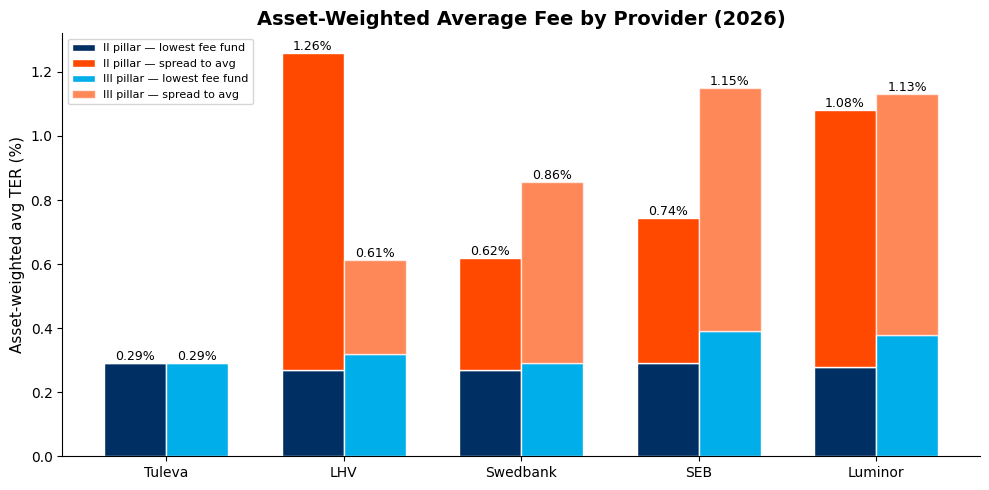

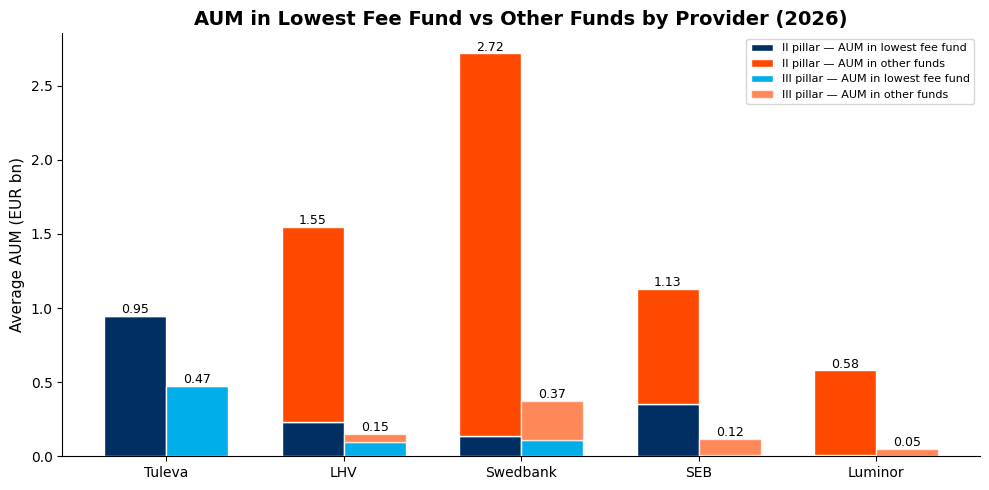

In [6]:
# Asset-weighted average fee by provider (current year)
latest = df[df['year'] == LATEST_YEAR]

wavg_data = []
for provider in PROVIDER_ORDER:
    for pillar in ['II', 'III']:
        sub = latest[(latest['provider'] == provider) & (latest['pillar'] == pillar)]
        if len(sub):
            min_ter = sub['ter'].min()
            low_aum = sub.loc[sub['ter'] == min_ter, 'avg_aum'].sum()
            rest_aum = sub.loc[sub['ter'] != min_ter, 'avg_aum'].sum()
            wavg_data.append({
                'provider': provider, 'pillar': pillar,
                'wavg_ter': weighted_avg(sub['ter'], sub['avg_aum']),
                'min_ter': min_ter,
                'total_aum': sub['avg_aum'].sum(),
                'low_aum': low_aum,
                'rest_aum': rest_aum,
                'funds': sub['fund'].nunique(),
            })
wavg_df = pd.DataFrame(wavg_data)
wavg_pivot = wavg_df.pivot(index='provider', columns='pillar', values='wavg_ter').reindex(PROVIDER_ORDER)
min_pivot = wavg_df.pivot(index='provider', columns='pillar', values='min_ter').reindex(PROVIDER_ORDER)
spread_pivot = wavg_pivot - min_pivot
low_aum_pivot = wavg_df.pivot(index='provider', columns='pillar', values='low_aum').reindex(PROVIDER_ORDER) / 1e9
rest_aum_pivot = wavg_df.pivot(index='provider', columns='pillar', values='rest_aum').reindex(PROVIDER_ORDER) / 1e9

# --- Chart 1: Fee breakdown (lowest fee + spread) ---
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(wavg_pivot))
w = 0.35

ax.bar(x - w/2, min_pivot['II'], w, color=TULEVA_NAVY, edgecolor='white', label='II pillar — lowest fee fund')
ax.bar(x - w/2, spread_pivot['II'], w, bottom=min_pivot['II'],
       color='#FF4800', edgecolor='white', label='II pillar — spread to avg')
ax.bar(x + w/2, min_pivot['III'], w, color=TULEVA_BLUE, edgecolor='white', label='III pillar — lowest fee fund')
ax.bar(x + w/2, spread_pivot['III'], w, bottom=min_pivot['III'],
       color='#FF4800', edgecolor='white', alpha=0.65, label='III pillar — spread to avg')

ax.set_xticks(x)
ax.set_xticklabels(wavg_pivot.index)
ax.set_ylabel('Asset-weighted avg TER (%)')
ax.set_title(f'Asset-Weighted Average Fee by Provider ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=8)

for i, provider in enumerate(PROVIDER_ORDER):
    for pillar, offset in [('II', -w/2), ('III', w/2)]:
        avg = wavg_pivot.loc[provider, pillar]
        if not np.isnan(avg):
            ax.text(i + offset, avg + 0.01, f'{avg:.2f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# --- Chart 2: AUM breakdown (lowest fee fund vs rest) ---
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - w/2, low_aum_pivot['II'], w, color=TULEVA_NAVY, edgecolor='white',
       label='II pillar — AUM in lowest fee fund')
ax.bar(x - w/2, rest_aum_pivot['II'], w, bottom=low_aum_pivot['II'],
       color='#FF4800', edgecolor='white', label='II pillar — AUM in other funds')
ax.bar(x + w/2, low_aum_pivot['III'], w, color=TULEVA_BLUE, edgecolor='white',
       label='III pillar — AUM in lowest fee fund')
ax.bar(x + w/2, rest_aum_pivot['III'], w, bottom=low_aum_pivot['III'],
       color='#FF4800', edgecolor='white', alpha=0.65, label='III pillar — AUM in other funds')

ax.set_xticks(x)
ax.set_xticklabels(wavg_pivot.index)
ax.set_ylabel('Average AUM (EUR bn)')
ax.set_title(f'AUM in Lowest Fee Fund vs Other Funds by Provider ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=8)

for i, provider in enumerate(PROVIDER_ORDER):
    for pillar, offset in [('II', -w/2), ('III', w/2)]:
        total = low_aum_pivot.loc[provider, pillar] + rest_aum_pivot.loc[provider, pillar]
        if not np.isnan(total) and total > 0:
            ax.text(i + offset, total + 0.02, f'{total:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

*Low fee in one fund does not translate to lower average fees paid by all investors. It is because each fund manager tends to lower fees only in funds that are rather insignificant in terms of AUM.*

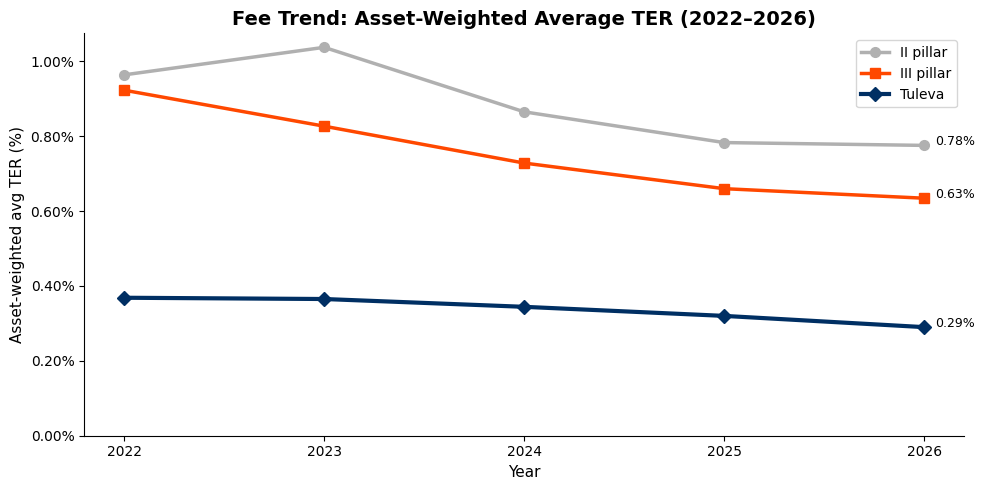

,II pillar,III pillar,Tuleva
year,,,
2022,0.964%,0.923%,0.368%
2023,1.037%,0.827%,0.365%
2024,0.865%,0.728%,0.344%
2025,0.783%,0.660%,0.320%
2026,0.775%,0.634%,0.290%


In [7]:
# Fee trend 2022-2026
trends = []
for year in sorted(df['year'].unique()):
    sub = df[df['year'] == year]
    ii = sub[sub['pillar'] == 'II']
    iii = sub[sub['pillar'] == 'III']
    tul = sub[sub['provider'] == 'Tuleva']
    trends.append({
        'year': year,
        'II pillar': weighted_avg(ii['ter'], ii['avg_aum']),
        'III pillar': weighted_avg(iii['ter'], iii['avg_aum']),
        'Tuleva': weighted_avg(tul['ter'], tul['avg_aum']),
    })
trend_df = pd.DataFrame(trends).set_index('year')

fig, ax = plt.subplots(figsize=(10, 5))
styles = {
    'II pillar': {'color': '#B0B0B0', 'linewidth': 2.5, 'marker': 'o'},
    'III pillar': {'color': '#FF4800', 'linewidth': 2.5, 'marker': 's'},
    'Tuleva': {'color': TULEVA_NAVY, 'linewidth': 3, 'marker': 'D'},
}
for col, style in styles.items():
    ax.plot(trend_df.index, trend_df[col], label=col, **style, markersize=7)

ax.set_ylim(0)
ax.set_xlabel('Year')
ax.set_ylabel('Asset-weighted avg TER (%)')
ax.set_title('Fee Trend: Asset-Weighted Average TER (2022–2026)', fontweight='bold')
ax.legend(fontsize=10)
ax.set_xticks(trend_df.index)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{x:.2f}%'))

# End-of-line labels
for col in trend_df.columns:
    last_val = trend_df[col].dropna().iloc[-1]
    last_year = trend_df[col].dropna().index[-1]
    ax.annotate(f'{last_val:.2f}%', (last_year, last_val),
                xytext=(8, 0), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

trend_df.style.format('{:.3f}%')

*Overall fees have decreased, but are still way higher than they should be.*

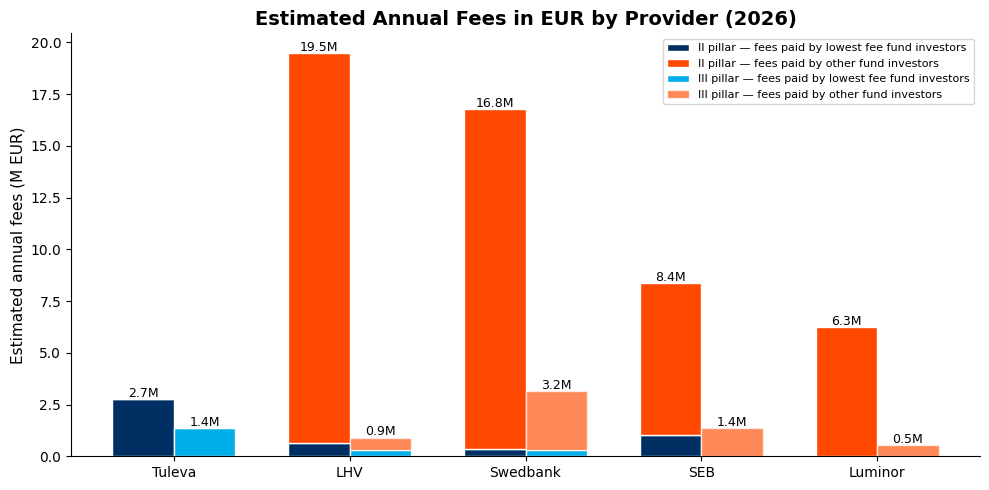

In [8]:
# Total fee revenue estimate by provider (latest year)
latest = df[df['year'] == LATEST_YEAR]

fee_data = []
for provider in PROVIDER_ORDER:
    for pillar in ['II', 'III']:
        sub = latest[(latest['provider'] == provider) & (latest['pillar'] == pillar)]
        if len(sub):
            min_ter = sub['ter'].min()
            low_fee = sub.loc[sub['ter'] == min_ter, 'fee_eur'].sum()
            rest_fee = sub.loc[sub['ter'] != min_ter, 'fee_eur'].sum()
            fee_data.append({
                'provider': provider, 'pillar': pillar,
                'low_fee': low_fee, 'rest_fee': rest_fee,
            })
fee_df = pd.DataFrame(fee_data)
low_fee_pivot = fee_df.pivot(index='provider', columns='pillar', values='low_fee').reindex(PROVIDER_ORDER) / 1e6
rest_fee_pivot = fee_df.pivot(index='provider', columns='pillar', values='rest_fee').reindex(PROVIDER_ORDER) / 1e6

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(PROVIDER_ORDER))
w = 0.35

# II pillar
ax.bar(x - w/2, low_fee_pivot['II'], w, color=TULEVA_NAVY, edgecolor='white',
       label='II pillar — fees paid by lowest fee fund investors')
ax.bar(x - w/2, rest_fee_pivot['II'], w, bottom=low_fee_pivot['II'],
       color='#FF4800', edgecolor='white', label='II pillar — fees paid by other fund investors')

# III pillar
ax.bar(x + w/2, low_fee_pivot['III'], w, color=TULEVA_BLUE, edgecolor='white',
       label='III pillar — fees paid by lowest fee fund investors')
ax.bar(x + w/2, rest_fee_pivot['III'], w, bottom=low_fee_pivot['III'],
       color='#FF4800', edgecolor='white', alpha=0.65, label='III pillar — fees paid by other fund investors')

ax.set_xticks(x)
ax.set_xticklabels(PROVIDER_ORDER)
ax.set_ylabel('Estimated annual fees (M EUR)')
ax.set_title(f'Estimated Annual Fees in EUR by Provider ({LATEST_YEAR})', fontweight='bold')
ax.legend(fontsize=8)

for i, provider in enumerate(PROVIDER_ORDER):
    for pillar, offset in [('II', -w/2), ('III', w/2)]:
        total = low_fee_pivot.loc[provider, pillar] + rest_fee_pivot.loc[provider, pillar]
        if not np.isnan(total) and total > 0:
            ax.text(i + offset, total + 0.1, f'{total:.1f}M', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

*It is not surprising that the fund management industry earns most of their revenue not from lowest cost funds.*

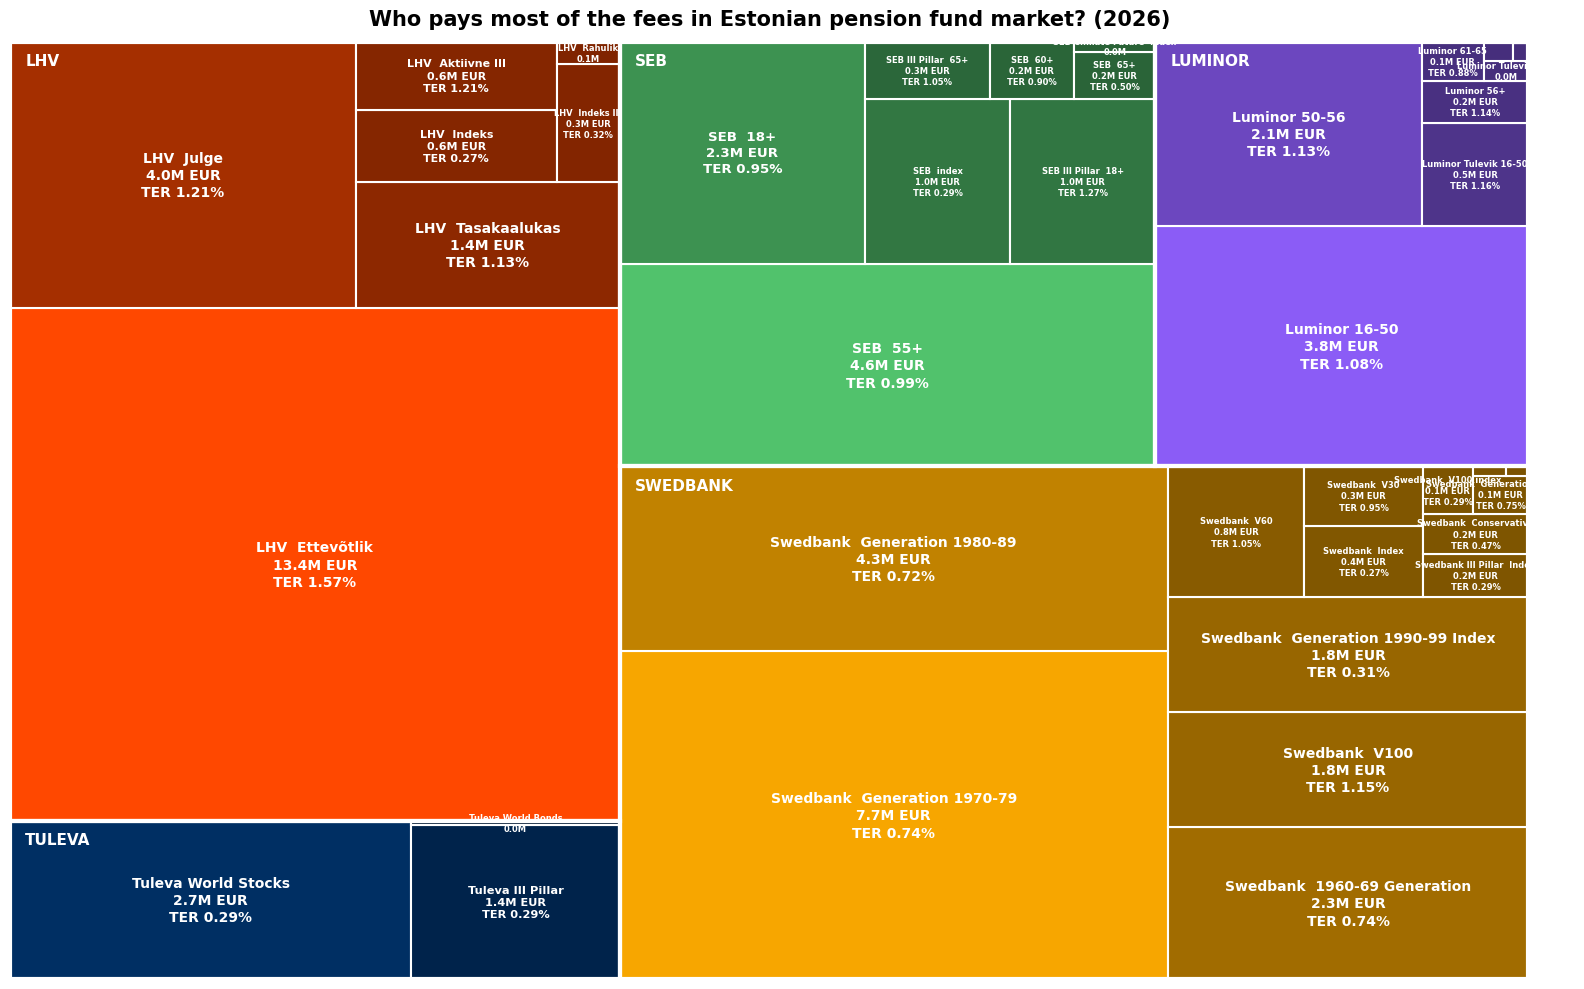

Total estimated annual fees: 61.0M EUR


In [9]:
import squarify
from matplotlib.colors import to_rgba

# Treemap: where pension fund investors pay the most fees
latest = df[df['year'] == LATEST_YEAR].copy()
latest['short_name'] = (latest['fund']
    .str.replace(r'Pensionifond|Pension Fund|Pension fund|pension fund', '', regex=True)
    .str.replace('(limited redemption)', '', regex=False)
    .str.strip())
latest['fee_M'] = latest['fee_eur'] / 1e6
latest = latest.sort_values('fee_eur', ascending=False)

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# First pass: allocate space per provider (like sectors)
provider_fees = latest.groupby('provider')['fee_eur'].sum().reindex(PROVIDER_ORDER).dropna()
provider_rects = squarify.squarify(
    squarify.normalize_sizes(provider_fees.values, 100, 100),
    0, 0, 100, 100)

for provider, prect in zip(provider_fees.index, provider_rects):
    px, py, pw, ph = prect['x'], prect['y'], prect['dx'], prect['dy']
    base_color = PROVIDER_COLORS[provider]

    # Draw provider border
    ax.add_patch(plt.Rectangle((px, py), pw, ph,
                                fill=False, edgecolor='white', linewidth=3, zorder=3))

    # Provider label at top-left
    ax.text(px + 1, py + ph - 1.2, provider.upper(),
            fontsize=11, fontweight='bold', color='white',
            va='top', ha='left', zorder=5)

    # Sub-treemap for funds within this provider
    sub = latest[latest['provider'] == provider].sort_values('fee_eur', ascending=False)
    if len(sub) == 0:
        continue

    # Vary lightness per fund: largest fee = full color, smaller = lighter
    max_fee = sub['fee_eur'].max()
    fund_rects = squarify.squarify(
        squarify.normalize_sizes(sub['fee_eur'].values, pw, ph),
        px, py, pw, ph)

    for (_, row), frect in zip(sub.iterrows(), fund_rects):
        fx, fy, fw, fh = frect['x'], frect['y'], frect['dx'], frect['dy']

        # Darken/lighten based on relative fee size within provider
        ratio = 0.5 + 0.5 * (row['fee_eur'] / max_fee)
        r, g, b, _ = to_rgba(base_color)
        color = (r * ratio, g * ratio, b * ratio, 1.0)

        ax.add_patch(plt.Rectangle((fx, fy), fw, fh,
                                    facecolor=color, edgecolor='white',
                                    linewidth=1.5, zorder=2))

        # Label: fund name + fee amount
        area = fw * fh
        if area > 15:
            label = f"{row['short_name']}\n{row['fee_M']:.1f}M EUR\nTER {row['ter']:.2f}%"
            fontsize = min(10, max(6, fw * 0.6))
            ax.text(fx + fw/2, fy + fh/2, label,
                    ha='center', va='center', fontsize=fontsize,
                    color='white', fontweight='bold', zorder=4,
                    linespacing=1.3)
        elif area > 5:
            label = f"{row['short_name']}\n{row['fee_M']:.1f}M"
            ax.text(fx + fw/2, fy + fh/2, label,
                    ha='center', va='center', fontsize=6,
                    color='white', fontweight='bold', zorder=4)

ax.set_title(f'Who pays most of the fees in Estonian pension fund market? ({LATEST_YEAR})',
             fontsize=15, fontweight='bold', pad=12)
ax.set_axis_off()

plt.tight_layout()
plt.show()

total_fees = latest['fee_eur'].sum() / 1e6
print(f'Total estimated annual fees: {total_fees:.1f}M EUR')